In [1]:
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import time
import matplotlib.pyplot as plt
from examples import utils

Step 1: read in the data

In [2]:
DATA_FILE = 'examples/data/birth_life_2010.txt'
data, n_samples = utils.read_birth_life_data(DATA_FILE)

Step 2: create PlaceHolder

In [3]:
X = tf.placeholder(tf.float32, name='X')
Y = tf.placeholder(tf.float32, name='Y')

Step 3: create weight and bias, initialized to 0

In [4]:
# w = tf.Variable(0.0, name='weights')
# b = tf.Variable(0.0, name='bias')
w = tf.get_variable('weights', initializer=tf.constant(0.0))
b = tf.get_variable('bias', initializer=tf.constant(0.0))

Step 4: build model to predict Y

In [5]:
Y_predicted = X * w +b

Step 5: use the square error as the loss function

In [6]:
loss = tf.square(Y-Y_predicted, name='loss')

Step 6: using gradient descent

In [7]:
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
opt = trainer.minimize(loss) #optimizer is also a tensor??

In [8]:
start = time.time()

Step 7: Initialize variables

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('./graphs/linear_reg', sess.graph)
    
    # step 8: train the model
    for i in range(100):
        total_loss = 0
        for x, y in data:
            o, l = sess.run([opt, loss], feed_dict={X:x, Y:y})
            total_loss += l
        print('Epoch {0}: {1}'.format(i, total_loss/n_samples))
    writer.close()
    # Step 9: output the values of w and b
    w_out, b_out = sess.run([w, b]) 
    

Epoch 0: 1661.863764550287
Epoch 1: 956.3224439573916
Epoch 2: 844.6737683409139
Epoch 3: 750.7312372197838
Epoch 4: 667.659830722252
Epoch 5: 594.1417484349327
Epoch 6: 529.0787271179651
Epoch 7: 471.5003584364135
Epoch 8: 420.5458252520938
Epoch 9: 375.45531067297253
Epoch 10: 335.55436177954664
Epoch 11: 300.24627770512666
Epoch 12: 269.00374521501146
Epoch 13: 241.3595776562824
Epoch 14: 216.9003910217238
Epoch 15: 195.25972397061292
Epoch 16: 176.1137731664483
Epoch 17: 159.17551683403158
Epoch 18: 144.19069889799545
Epoch 19: 130.93503690609023
Epoch 20: 119.20935661137888
Epoch 21: 108.83793506244884
Epoch 22: 99.66458668207358
Epoch 23: 91.55171666162971
Epoch 24: 84.37658985632197
Epoch 25: 78.03213362396008
Epoch 26: 72.42178616552172
Epoch 27: 67.46132107331957
Epoch 28: 63.07563027821873
Epoch 29: 59.19871881428714
Epoch 30: 55.77163058824279
Epoch 31: 52.742706123048954
Epoch 32: 50.06563247971506
Epoch 33: 47.70006537150391
Epoch 34: 45.61017402416389
Epoch 35: 43.7637948

Took: 5.416000 seconds


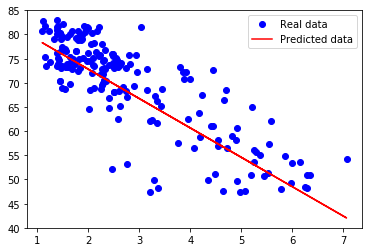

In [10]:
print('Took: %f seconds' %(time.time() - start))

# plot the results
plt.plot(data[:,0], data[:,1], 'bo', label='Real data')
plt.plot(data[:,0], data[:,0] * w_out + b_out, 'r', label='Predicted data')
plt.legend()
plt.show()

Huber loss

In [11]:
def huber_loss(labels, predictions, delta=14.0):
    residual = tf.abs(labels - predictions)
    def f1():
        return 0.5*tf.square(residual)
    def f2():
        return delta * residual - 0.5*tf.square(delta)
    return tf.cond(residual<delta, f1, f2)

**tf.data**

In [12]:
data, n_samples = utils.read_birth_life_data(DATA_FILE)

tf.data.Dataset.from_tensor_slices((features, labels))

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((data[:,0], data[:,1]))

In [14]:
print(dataset.output_types)		# >> (tf.float32, tf.float32)
print(dataset.output_shapes)# >> (TensorShape([]), TensorShape([]))

(tf.float32, tf.float32)
(TensorShape([]), TensorShape([]))


**tf.data.Iterator**

In [15]:
iterator = dataset.make_one_shot_iterator()
#Iterate data exactaly ONCE, no need to initialization
X, Y = iterator.get_next()         # X is the birth rate, Y is the life expectancy
with tf.Session() as sess:
	print(sess.run([X, Y]))		# >> [1.822, 74.82825]
	print(sess.run([X, Y]))		# >> [3.869, 70.81949]
	print(sess.run([X, Y]))		# >> [3.911, 72.15066]

[1.822, 74.82825]
[3.869, 70.81949]
[3.911, 72.15066]


In [16]:
iterator = dataset.make_initializable_iterator()
# Iterate as many times as we want, need to initialize with each epoch
for i in range(100): 
        sess.run(iterator.initializer) 
        total_loss = 0
        try:
            while True:
                sess.run([opt]) 
        except tf.errors.OutOfRangeError:
            pass

RuntimeError: Attempted to use a closed Session.

Handling data in Tensorflow

In [17]:
dataset = dataset.shuffle(1000)
dataset = dataset.repeat(100)
dataset = dataset.batch(128)
# dataset = dataset.map(lambda x: tf.one_hot(x, 10)) 
# convert each elem of dataset to one_hot vector

** Should we always use tf.data? **
* For prototyping, feed dict can be faster and easier to write (pythonic)
* tf.data is tricky to use when you have complicated preprocessing or multiple data sources
* NLP data is normally just a sequence of integers. In this case, transferring the data over to GPU is pretty quick, so the speedup of tf.data isn't that large


**Optimizers**

In [18]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

List of optimizaer:

* tf.train.GradientDescentOptimizer
* tf.train.AdagradOptimizer
* tf.train.MomentumOptimizer
* tf.train.AdamOptimizer
* tf.train.FtrlOptimizer
* tf.train.RMSPropOptimizer
...


**MINIST**

Inference: Y_predicted = softmax(X * w + b)

Cross entropy loss: -log(Y_predicted)


In [19]:
from tensorflow.examples.tutorials.mnist import input_data
MNIST = input_data.read_data_sets('example/data/mnist',one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting example/data/mnist\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting example/data/mnist\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting example/data/mnist\t10k-images-idx3-ubyte.gz
Extracting example/data/mnist\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [20]:
mnist_folder = 'data/mnist'
utils.download_mnist(mnist_folder)

data/mnist\train-images-idx3-ubyte.gz already exists
data/mnist\train-labels-idx1-ubyte.gz already exists
data/mnist\t10k-images-idx3-ubyte.gz already exists
data/mnist\t10k-labels-idx1-ubyte.gz already exists


In [21]:
train, val, test = utils.read_mnist(mnist_folder, flatten=True)

In [22]:
train_data = tf.data.Dataset.from_tensor_slices(train)
train_data = train_data.shuffle(10000) # optional
test_data = tf.data.Dataset.from_tensor_slices(test)

Create iterator

In [23]:
iterator = train_data.make_initializable_iterator()
img, label = iterator.get_next()

> Can only do inference with train_data. 
> Need to build another subgraph with another iterator for test_data!!!

In [24]:
iterator = tf.data.Iterator.from_structure(train_data.output_types,
                                          train_data.output_shapes)
img, label = iterator.get_next()

In [25]:
train_init = iterator.make_initializer(train_data)
test_init = iterator.make_initializer(test_data)

Now I can create two initializer

In [26]:
with tf.Session() as sess:
    for i in range(10):
        sess.run(train_init)
        try:
            while True:
                _, l = sess.run([opt, loss])
        except tf.errors.OutOfRangeError:
            pass
    sess.run(test_init)
    try:
        while True:
            sess.run(accuracy)
    except tf.errors.OutOfRangeError:
        pass

InvalidArgumentError: You must feed a value for placeholder tensor 'X' with dtype float
	 [[Node: X = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'X', defined at:
  File "e:\anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "e:\anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "e:\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "e:\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "e:\anaconda3\envs\tensorflow\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 759, in _run_callback
    ret = callback()
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-604b02a15378>", line 1, in <module>
    X = tf.placeholder(tf.float32, name='X')
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 5835, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "e:\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'X' with dtype float
	 [[Node: X = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
